<a href="https://colab.research.google.com/github/Francky46/AttritionPrediction/blob/main/AttritionPrediction2.0..ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rédacteurs

- Francky MARTINI
- Yoann CJ
- Theotime COLINET

# Préambule : Ethique et responsabilité dans l'usage de l'IA

L’intelligence artificielle (IA) est un outil puissant, capable d’apporter des éclairages précieux dans de nombreux domaines, notamment dans la prédiction de l’attrition des personnels en entreprise. Toutefois, comme tout outil technologique, son usage doit être encadré par des principes éthiques clairs et une responsabilité assumée par ses utilisateurs.

Nous affirmons ainsi que la responsabilité de l’usage de cette IA incombe aux utilisateurs et non à l’IA elle-même. L’IA n’a ni intention ni discernement moral ; elle ne fait qu’exécuter des algorithmes sur la base des données qui lui sont fournies. C’est donc aux professionnels qui l’exploitent d’en faire un usage éthique et conforme aux bonnes pratiques.

Dans cette optique, nous insistons sur le fait que cette IA doit être strictement utilisée pour son objectif initial : la prédiction de l’attrition des employés. Toute autre utilisation, notamment à des fins discriminatoires, est inacceptable et contraire aux principes de respect et d’équité. Des variables sensibles telles que le sexe, l’âge ou la situation matrimoniale pourraient, si elles étaient utilisées de manière inappropriée, engendrer des décisions biaisées et injustes. Il est donc primordial de sensibiliser les utilisateurs aux risques d’un usage inapproprié et de condamner fermement toute dérive contraire à l’éthique.

Nous prônons ainsi une approche où l’IA reste un outil d’aide à la décision et non un moyen de renforcer des pratiques discriminatoires. La transparence, la responsabilité individuelle et la vigilance sont essentielles pour garantir que cette technologie soit mise au service de décisions justes et éclairées.

# 1) Importation des librairies

In [153]:
from cProfile import label

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Pour la séparation des données en train/test
from sklearn.model_selection import train_test_split

# Pour la création et l'évaluation de modèles
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier


# Pour l'optimisation des hyperparamètres
from sklearn.model_selection import GridSearchCV

# 2) Chargement des données

In [70]:
# Lis les différents fichiers CSV
folder = "src/"
df_general = pd.read_csv(folder + "general_data.csv")
df_emp_survey = pd.read_csv(folder + "employee_survey_data.csv")
df_mgr_survey = pd.read_csv(folder + "manager_survey_data.csv")
df_in_time = pd.read_csv(folder + "in_time.csv")
df_out_time = pd.read_csv(folder + "out_time.csv")

# 3) Exploration des données

In [71]:
print("=== General Data ===")
print(df_general.head(), "\n")
print(df_general.info(), "\n")

print("=== Employee Survey Data ===")
print(df_emp_survey.head(), "\n")
print(df_emp_survey.info(), "\n")

print("=== Manager Survey Data ===")
print(df_mgr_survey.head(), "\n")
print(df_mgr_survey.info(), "\n")

print("=== In Time Data ===")
print(df_in_time.head(), "\n")
print(df_in_time.info(), "\n")

print("=== Out Time Data ===")
print(df_out_time.head(), "\n")
print(df_out_time.info(), "\n")

=== General Data ===
   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   NumCompaniesWorked Over18 PercentSalaryHike  StandardHours  \


 # 4) Fusion des données

## 4.1) Merge general_data, employee_survey_data et manager_survey_data

In [72]:
df_merged = pd.merge(df_general, df_emp_survey, on="EmployeeID")
df_merged = pd.merge(df_merged, df_mgr_survey, on="EmployeeID")

## 4.2) Calculer le nombre d'heures travaillées par jour
On va aussi créer des features à partir de df_in_time et df_out_time (par exemple : nombre d'heures travaillées moyennes). </br>
Les colonnes de in_time / out_time sont des dates/heures pour chaque jour travaillé.

In [73]:
#  - Pour chaque employé, on peut calculer la différence out_time - in_time (en heures) pour chaque jour.
#  - Ensuite on peut faire la moyenne sur toutes les dates disponibles pour obtenir "moyenne d'heures/jour"

# Replace Unnamed header by EmployeeID
df_in_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)
df_out_time.rename(columns={"Unnamed: 0": "EmployeeID"}, inplace=True)

# Suppression de la première colonne "EmployeeID" pour faciliter les opérations (on la conserve à part)
df_in_time_id = df_in_time['EmployeeID']
df_out_time_id = df_out_time['EmployeeID']

# On exclut la colonne 'EmployeeID' des dataframes pour ne traiter que les colonnes date/heure
df_in_time_dates = df_in_time.drop(['EmployeeID'], axis=1)
df_out_time_dates = df_out_time.drop(['EmployeeID'], axis=1)

# Conversion des valeurs string en datetime pour permettre la soustraction des temps
# Nota : Certaines valeurs sont "NA" => conversion en NaT
df_in_time_dates = df_in_time_dates.apply(pd.to_datetime, errors='coerce')
df_out_time_dates = df_out_time_dates.apply(pd.to_datetime, errors='coerce')

# Calcul de la différence (out_time - in_time) par employé et par jour
df_hours = df_out_time_dates - df_in_time_dates  # Résultat en format timedelta

# Convertir les timedelta en nombre d'heures (float)
df_hours = df_hours.apply(lambda x: x.dt.total_seconds() / 3600)

# Exemple : Calcul d'une statistique agrégée (moyenne d'heures/jour travaillé) pour chaque employé
df_hours_mean = df_hours.mean(axis=1)

# On veut garder la différence entre StandardHours et mean_work_hours
df_hours['mean_work_hours_diff'] = df_hours_mean - df_merged['StandardHours']

# On peut aussi calculer le nombre de jours d'absence (journées entières manquantes => in_time = NA & out_time = NA)
# ou le ratio de jours travaillés vs le total possible, etc.
# Ci-dessous un exemple de calcul du nombre de jours (colonnes) pour lesquels l'entrée est manquante
nb_jours_total = df_hours.shape[1] - 1  # -1 car la dernière colonne est 'mean_work_hours' qu'on vient d'ajouter
df_hours['absent_days'] = df_hours.iloc[:, :-1].isna().sum(axis=1)  # On ne compte pas la col. 'mean_work_hours'

# Concaténer EmployeeID pour pouvoir refusionner
df_hours_final = pd.concat([df_in_time_id, df_hours[['mean_work_hours_diff','absent_days']]], axis=1)

# Heure d'arrivé moyenne
df_hours_final['Avg_Hours_In'] = df_in_time_dates.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

# Heure de départ moyenne
df_hours_final['Avg_Hours_Out'] = df_out_time_dates.apply(
    lambda row: row.dropna().dt.hour.mean() + row.dropna().dt.minute.mean() / 60
    if not row.dropna().empty else None, axis=1
)

## 4.3) Merge avec df_merged pour rajouter ces nouvelles features

In [74]:
df_merged = pd.merge(df_merged, df_hours_final, on='EmployeeID', how='left')

print("\n=== Aperçu des données fusionnées ===\n")
print(df_merged.head())
print(df_merged.info())


=== Aperçu des données fusionnées ===

   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   YearsWithCurrManager EnvironmentSatisfactio

# Analyse de la distribution normale des données

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

def plot_normal_distribution(df, column_name, log_transform=False, log_base='10'):
    """
    Trace un histogramme (densité) de la colonne `column_name` d'un DataFrame `df`
    et superpose la courbe de la distribution normale basée sur la moyenne et
    l'écart-type (sur données brutes ou log-transformées).

    Paramètres:
    -----------
    df : pd.DataFrame
        Votre DataFrame
    column_name : str
        Nom de la colonne à tracer
    log_transform : bool
        Si True, applique un log sur les valeurs de la colonne avant le tracé.
    log_base : str
        - '10' pour un log base 10 (log10)
        - 'e' pour un log naturel (ln)
    """
    data = df[column_name].dropna()

    if log_transform:
        if log_base == '10':
            data = np.log10(data + 1)
            suffix = " (log10)"
        elif log_base == 'e':
            data = np.log(data + 1)
            suffix = " (ln)"
        else:
            raise ValueError("log_base doit être '10' ou 'e'")
    else:
        suffix = ""


    mean = data.mean()
    std = data.std()

    x_min = mean - 3 * std
    x_max = mean + 3 * std

    if x_min == x_max:
        x_min = mean - 1
        x_max = mean + 1

    x = np.linspace(x_min, x_max, 200)

    pdf = norm.pdf(x, mean, std)
    plt.figure(figsize=(8, 6))
    sns.histplot(data, kde=False, stat='density', bins=30, color='skyblue', label='Données')

    plt.plot(x, pdf, color='red', linewidth=2, label='Distribution normale')
    plt.xlim(x_min, x_max)

    plt.title(f"Distribution de la colonne: {column_name}{suffix}")
    plt.xlabel(f"{column_name}{suffix}")
    plt.ylabel("Densité")
    plt.legend()

    plt.show()


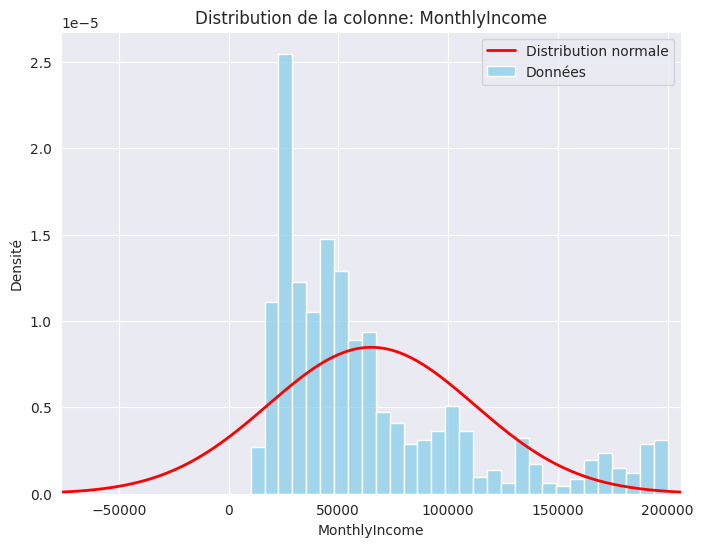

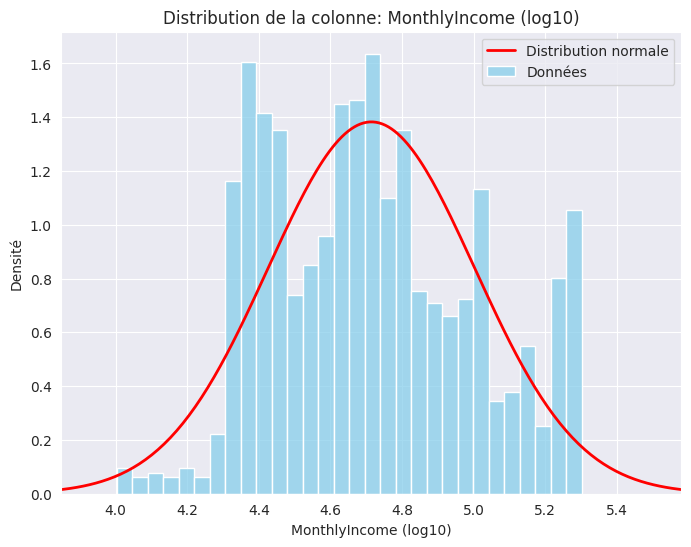

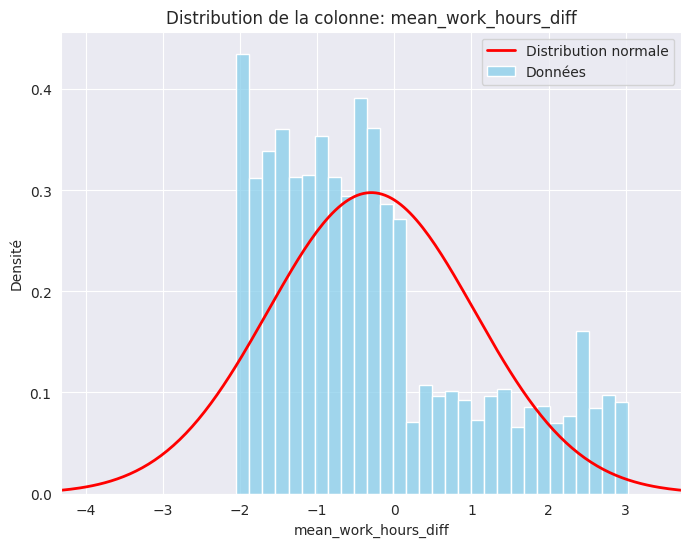

In [76]:
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=False)
plot_normal_distribution(df_merged, 'MonthlyIncome', log_transform=True, log_base='10')
plot_normal_distribution(df_merged, 'mean_work_hours_diff', log_transform=False, log_base='10')

# 5) Nettoyage et préparation des données

## 5.1) Gérer les valeurs manquantes

In [77]:
# On regarde déjà combien de valeurs manquantes par colonne
missing_values = df_merged.isnull().sum()
print("\n=== Nombre de valeurs manquantes par colonne ===\n", missing_values)


=== Nombre de valeurs manquantes par colonne ===
 Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeID                  0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
JobInvolvement              0
PerformanceRating           0
mean_work_hours_diff        0
absent_days                 0
Avg_Hours_In       

In [78]:
# Dropna sur la colonne Attrition car c'est notre target
df_merged = df_merged.dropna(subset=['Attrition'])

In [79]:
# Exemple d'imputation : pour 'mean_work_hours' et 'absent_days', on remplace les NaN par la moyenne
# On privilégie la moyenne ici car les valeurs de type durée (heures) ne sont pas fortement bornées
df_merged['mean_work_hours_diff'] = df_merged['mean_work_hours_diff'].fillna(df_merged['mean_work_hours_diff'].mean())
print(f"Filled missing values for column 'mean_work_hours_diff' with mean value {df_merged['mean_work_hours_diff'].mean()}")
df_merged['absent_days'] = df_merged['absent_days'].fillna(df_merged['absent_days'].mean())
print(f"Filled missing values for column 'absent_days' with mean value {df_merged['absent_days'].mean()}")

Filled missing values for column 'mean_work_hours_diff' with mean value -0.2992082155218533
Filled missing values for column 'absent_days' with mean value 24.73469387755102


In [80]:
# Pour les colonnes de satisfaction ou autres colonnes numériques manquantes, on peut aussi faire un fillna
# On privilégie la médiane
num_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
            'JobInvolvement', 'PerformanceRating', 'TotalWorkingYears', 'NumCompaniesWorked',]
for col in num_cols:
    if col in df_merged.columns:
        df_merged[col] = df_merged[col].fillna(df_merged[col].median())
        print(f"Filled missing values for column {col} with median value {df_merged[col].median()}")


Filled missing values for column EnvironmentSatisfaction with median value 3.0
Filled missing values for column JobSatisfaction with median value 3.0
Filled missing values for column WorkLifeBalance with median value 3.0
Filled missing values for column JobInvolvement with median value 3.0
Filled missing values for column PerformanceRating with median value 3.0
Filled missing values for column TotalWorkingYears with median value 10.0
Filled missing values for column NumCompaniesWorked with median value 2.0


## 5.2) Nettoyage de certaines colonnes (ex: Over18, EmployeeCount, StandardHours)

In [81]:
# On remarque souvent dans ce dataset "EmployeeCount" est toujours 1 => pas d'intérêt
# "Over18" est toujours "Y", "StandardHours" est souvent 8 => on peut les drop
cols_to_drop = ['Over18','StandardHours','EmployeeCount']
for c in cols_to_drop:
    if c in df_merged.columns:
        df_merged.drop(c, axis=1, inplace=True, errors='ignore')

## 5.3) Conversion de colonnes catégorielles en numériques

In [82]:
# Par exemple, Attrition = Yes/No, Gender = Male/Female, etc.
# On peut les encoder, soit via LabelEncoder, soit via OneHotEncoder
# Commençons par un label encoding simple pour la variable cible

df_merged['Attrition'] = df_merged['Attrition'].map({'Yes':1, 'No':0})

# Autres colonnes catégorielles (BusinessTravel, Department, EducationField, Gender, MaritalStatus, JobRole...)
cat_cols = ['BusinessTravel','Department','EducationField','Gender','MaritalStatus','JobRole']

# On va faire un one-hot-encoding rapide:
df_merged = pd.get_dummies(df_merged, columns=cat_cols, drop_first=True)

# 6) Séparation des données en train/test

In [83]:
# On sépare la cible (Attrition) des features

X = df_merged.drop(['EmployeeID','Attrition'], axis=1)
y = df_merged['Attrition']

# Ensuite on fait un split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 7) scaling et entraînements

In [84]:
# Selon le modèle (Logistic Regression par exemple), il peut être intéressant de standardiser
# Ici on va montrer un exemple de pipeline manuel (scaling + logistic regression).

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 7.1) Entrainement d'un modèle de Logistic Regression et Arbre de décision

On peut constater que les résultats sont prométeurs pour le modèle d'arbre de décision. Nous pouvons toutefois effectuer une phase de tuning pour améliorer les performances en trouvant les meilleurs hyperparamètres.

In [97]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=500),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:,1]

    print(f"\n=== {name} ===")
    print("Accuracy : ", accuracy_score(y_test, y_pred))
    print("ROC AUC  : ", roc_auc_score(y_test, y_proba))
    print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred))
    print("Classification report :\n", classification_report(y_test, y_pred))


=== Logistic Regression ===
Accuracy :  0.8571428571428571
ROC AUC  :  0.8035359302964937
Matrice de confusion :
 [[1077   33]
 [ 156   57]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.63      0.27      0.38       213

    accuracy                           0.86      1323
   macro avg       0.75      0.62      0.65      1323
weighted avg       0.83      0.86      0.83      1323


=== Decision Tree ===
Accuracy :  0.9523809523809523
ROC AUC  :  0.9109186651440172
Matrice de confusion :
 [[1079   31]
 [  32  181]]
Classification report :
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1110
           1       0.85      0.85      0.85       213

    accuracy                           0.95      1323
   macro avg       0.91      0.91      0.91      1323
weighted avg       0.95      0.95      0.95      1323



## 7.2) Tuning des hyperparamètres pour les modèles de Logistic Regression et Arbre de décision

Pour chaque modèle, on va utiliser GridSearchCV pour trouver les meilleurs hyperparamètres. </br>
Nous remarquons que pour la régression logistique, les meilleurs hyperparamètres sont C=0.01, max_iter=100 et solver='lbfgs' avec un score de 0.85. </br>
Pour l'arbre de décision, les meilleurs hyperparamètres sont criterion='entropy', max_depth=20 et min_samples_split=2 avec un score de 0.93.

Pour améliorer les performances, nous pouvons utiliser des ensembles de modèles (Random Forest, Gradient Boosting, etc.) ou des méthodes de stacking.

### 7.2.1) Logistic Regression

Fitting 5 folds for each of 30 candidates, totalling 150 fits
=== Logistic Regression - Meilleurs hyperparamètres ===
Best Params : {'C': 0.1, 'max_iter': 100, 'solver': 'lbfgs'}
Best Score  : 0.8571425574210739

=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===
Accuracy : 0.854875283446712
ROC AUC  : 0.8018229497102736
Matrice de confusion :
 [[1077   33]
 [ 159   54]]
Classification report :
               precision    recall  f1-score   support

           0       0.87      0.97      0.92      1110
           1       0.62      0.25      0.36       213

    accuracy                           0.85      1323
   macro avg       0.75      0.61      0.64      1323
weighted avg       0.83      0.85      0.83      1323



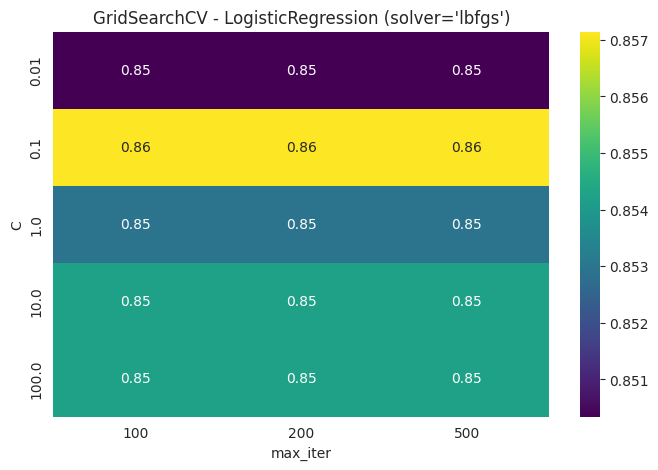

In [107]:
# Exemple de grille de paramètres (simple).
# Attention : certaines combinaisons penalty/solver peuvent être incompatibles.
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],         # Coefficient de régularisation
    'solver': ['liblinear', 'lbfgs'],     # Solveur
    'max_iter': [100, 200, 500]           # Nombre itérations max
    # 'penalty': ['l1','l2']  # <--- l1 nécessite solver='liblinear';
                              #      si on veut tester l1, il faut ajuster la grille
}

# Création de l'instance LogisticRegression
lr_model = LogisticRegression(random_state=42)

# GridSearchCV : 5-fold cross-validation, scoring basé sur l'accuracy (ou 'roc_auc', etc.)
grid_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring='accuracy',        # ou 'roc_auc'
    cv=5,                      # 5 folds
    verbose=1,                 # pour voir la progression
    n_jobs=-1                  # utilise tous les coeurs dispo
)

# Entraînement du GridSearchCV
grid_lr.fit(X_train_scaled, y_train)

# Récupération des meilleurs paramètres et score
print("=== Logistic Regression - Meilleurs hyperparamètres ===")
print("Best Params :", grid_lr.best_params_)
print("Best Score  :", grid_lr.best_score_)

# On peut maintenant re-prédire sur le test set avec le meilleur modèle trouvé
best_lr = grid_lr.best_estimator_
y_pred_best_lr = best_lr.predict(X_test_scaled)
y_proba_best_lr = best_lr.predict_proba(X_test_scaled)[:,1]

print("\n=== Évaluation sur le jeu de test (LogisticRegression avec meilleurs params) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_lr))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_lr))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_lr))
print("Classification report :\n", classification_report(y_test, y_pred_best_lr))

# Exemple : on peut faire un DataFrame à partir de grid_lr.cv_results_ pour tracer un heatmap
# entre C et max_iter, en séparant par solver.
# Cela nécessite un pivot de la table.

results_lr = pd.DataFrame(grid_lr.cv_results_)

# Pour simplifier, on ne visualise que le solver='lbfgs', par exemple
df_lbfgs = results_lr[ results_lr['param_solver'] == 'lbfgs' ]
# Pivot => index: param_C, columns: param_max_iter, values: mean_test_score
pivot_lbfgs = df_lbfgs.pivot(
    index='param_C',
    columns='param_max_iter',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_lbfgs, annot=True, cmap='viridis')
plt.title("GridSearchCV - LogisticRegression (solver='lbfgs')")
plt.ylabel("C")
plt.xlabel("max_iter")
plt.show()

### 7.2.2) Decision Tree

Fitting 5 folds for each of 24 candidates, totalling 120 fits

=== Decision Tree - Meilleurs hyperparamètres ===
Best Params : {'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 2}
Best Score  : 0.9332651466276427


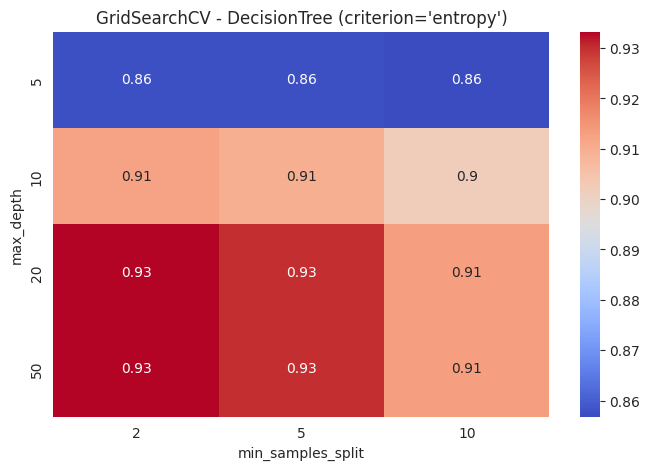

In [154]:
# Exemple de grille de paramètres (simple)
param_grid_dt = {
    'max_depth': [5, 10, 20, 50], # Profondeur de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons pour spliter un noeud
    'criterion': ['gini', 'entropy'] # Métrique pour mesurer la qualité de la split
}

dt_model = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
print("\n=== Decision Tree - Meilleurs hyperparamètres ===")
print("Best Params :", grid_dt.best_params_)
print("Best Score  :", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

# Affichage du graphique
results_dt = pd.DataFrame(grid_dt.cv_results_)
df_gini = results_dt[ results_dt['param_criterion'] == 'entropy' ]
pivot_dt = df_gini.pivot(
    index='param_max_depth',
    columns='param_min_samples_split',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_dt, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - DecisionTree (criterion='entropy')")
plt.ylabel("max_depth")
plt.xlabel("min_samples_split")
plt.show()


# 7.3) Entrainement d'ensembles de modèles

### 7.3.1) Entrainement et tuning d'un BaggingClassifier une Régression Logistique

In [144]:
# Exemple de grille de paramètres
param_grid_bagging = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

# On utilise le DecisionTreeClassifier comme base_estimator
lr_model = LogisticRegression(random_state=42, C= 0.1, max_iter= 100, solver='lbfgs')

bagging_model = BaggingClassifier(best_lr, random_state=42)

grid_bagging = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_grid_bagging,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_bagging.fit(X_train, y_train)
print("\n=== BaggingClassifier (DecisionTree) - Meilleurs hyperparamètres ===")
print("Best Params :", grid_bagging.best_params_)
print("Best Score  :", grid_bagging.best_score_)

best_bagging = grid_bagging.best_estimator_
y_pred_best_bagging = best_bagging.predict(X_test_scaled)
y_proba_best_bagging = best_bagging.predict_proba(X_test_scaled)[:,1]

print("\n=== Évaluation sur le jeu de test (BaggingClassifier avec DecisionTree) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_bagging))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_bagging))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_bagging))
print("Classification report :\n", classification_report(y_test, y_pred_best_bagging))

# Affichage du graphique
results_bagging = pd.DataFrame(grid_bagging.cv_results_)
df_max_samples = results_bagging[ results_bagging['param_max_features'] == 1.0 ]
pivot_bagging = df_max_samples.pivot(
    index='param_n_estimators',
    columns='param_max_samples',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_bagging, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - BaggingClassifier (DecisionTree, max_features=1.0)")
plt.ylabel("n_estimators")
plt.xlabel("max_samples")
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/francky/PycharmProjects/AttritionPrediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/francky/PycharmProjects/AttritionPrediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

KeyboardInterrupt: 

### 7.3.2) Entrainement et tuning d'un Boosting avec un Logistic Regression

In [145]:
# Exemple de grille de paramètres pour AdaBoost
param_grid_boosting = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0],
}
# 
boosting_model = AdaBoostClassifier(best_lr, random_state=42)

grid_boosting = GridSearchCV(
    estimator=boosting_model,
    param_grid=param_grid_boosting,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_boosting.fit(X_train, y_train)
print("\n=== BoostinggClassifier (LogisticRegression) - Meilleurs hyperparamètres ===")
print("Best Params :", grid_boosting.best_params_)
print("Best Score  :", grid_boosting.best_score_)

best_boosting = grid_boosting.best_estimator_
y_pred_best_boosting = best_boosting.predict(X_test_scaled)
y_proba_best_boosting = best_boosting.predict_proba(X_test_scaled)[:,1]

print("\n=== Évaluation sur le jeu de test (boosting avec LogisticREgression) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_boosting))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_boosting))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_boosting))
print("Classification report :\n", classification_report(y_test, y_pred_best_boosting))

# Affichage du graphique
results_boosting = pd.DataFrame(grid_boosting.cv_results_)
df_max_samples = results_boosting[ results_boosting['param_max_features'] == 1.0 ]
pivot_rotation_forest = df_max_samples.pivot(
    index='param_n_estimators',
    columns='param_max_samples',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rotation_forest, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - BoostingClassifier (LogisticRegression, max_features=1.0)")
plt.ylabel("n_estimators")
plt.xlabel("max_samples")
plt.show()

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/francky/PycharmProjects/AttritionPrediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/francky/PycharmProjects/AttritionPrediction/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    htt

KeyboardInterrupt: 

### 7.3.3) Entrainement et tuning d'un Stacking de Logistic Regression et Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits

=== StackingClassifier (LogisticRegression + DecisionTree) - Meilleurs hyperparamètres ===
Best Params : {'final_estimator__C': 1, 'stack_method': 'auto'}
Best Score  : 0.9345606940357613

=== Évaluation sur le jeu de test (Stacking avec LogisticRegression et DecisionTree) ===
Accuracy : 0.9727891156462585
ROC AUC  : 0.9765046736877723
Matrice de confusion :
 [[1089   21]
 [  15  198]]
Classification report :
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      1110
           1       0.90      0.93      0.92       213

    accuracy                           0.97      1323
   macro avg       0.95      0.96      0.95      1323
weighted avg       0.97      0.97      0.97      1323



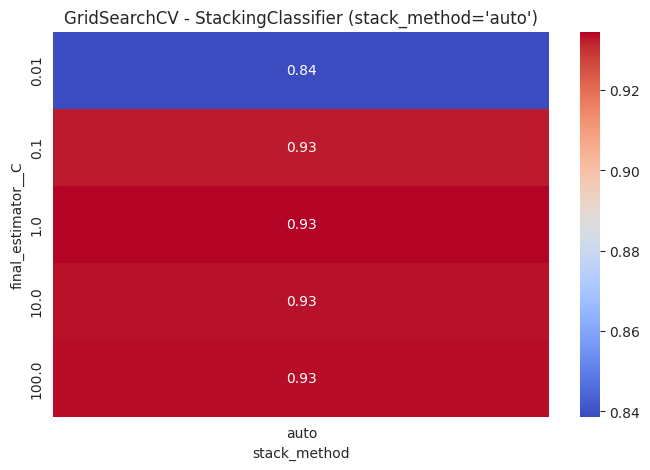

In [160]:
# Exemple de grille de paramètres
param_grid_stacking = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100],
    'stack_method': ['auto', 'predict_proba']
}

stacking_model = StackingClassifier(
    estimators=[('lr', best_lr), ('dt', best_dt)],
    final_estimator=LogisticRegression(random_state=42)
)

grid_stacking = GridSearchCV(
    estimator=stacking_model,
    param_grid=param_grid_stacking,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_stacking.fit(X_train_scaled, y_train)
print("\n=== StackingClassifier (LogisticRegression + DecisionTree) - Meilleurs hyperparamètres ===")
print("Best Params :", grid_stacking.best_params_)
print("Best Score  :", grid_stacking.best_score_)

best_stacking = grid_stacking.best_estimator_
y_pred_best_stacking = best_stacking.predict(X_test_scaled)
y_proba_best_stacking = best_stacking.predict_proba(X_test_scaled)[:,1]

print("\n=== Évaluation sur le jeu de test (Stacking avec LogisticRegression et DecisionTree) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_stacking))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_stacking))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_stacking))
print("Classification report :\n", classification_report(y_test, y_pred_best_stacking))

# Affichage du graphique
results_stacking = pd.DataFrame(grid_stacking.cv_results_)
df_auto = results_stacking[ results_stacking['param_stack_method'] == 'auto' ]
pivot_stacking = df_auto.pivot(
    index='param_final_estimator__C',
    columns='param_stack_method',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_stacking, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - StackingClassifier (stack_method='auto')")
plt.ylabel("final_estimator__C")
plt.xlabel("stack_method")
plt.show()


### 7.3.2) Entrainement et tuning d'un Random Forest 

Fitting 5 folds for each of 36 candidates, totalling 180 fits

=== Random Forest - Meilleurs hyperparamètres ===
Best Params : {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Score  : 0.9604847550261469

=== Évaluation sur le jeu de test (RandomForest avec meilleurs params) ===
Accuracy : 0.9788359788359788
ROC AUC  : 0.9928477773548197
Matrice de confusion :
 [[1107    3]
 [  25  188]]
Classification report :
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1110
           1       0.98      0.88      0.93       213

    accuracy                           0.98      1323
   macro avg       0.98      0.94      0.96      1323
weighted avg       0.98      0.98      0.98      1323



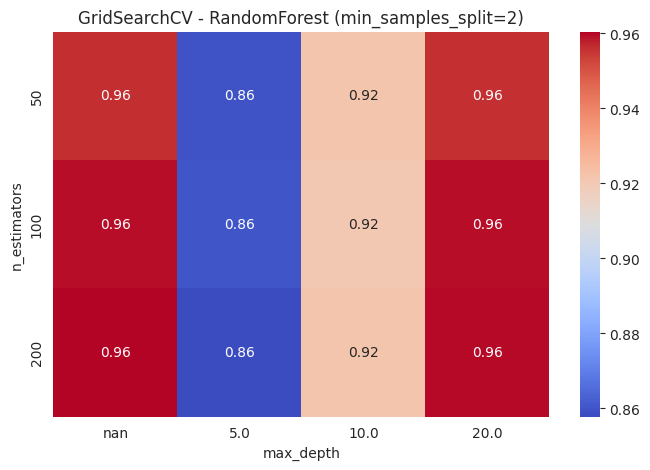

In [123]:
# Exemple de grille de paramètres
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
    # on peut rajouter 'max_features', 'min_samples_leaf', etc. selon les besoins
}

# l'objectif du random_state est de garantir la reproductibilité des résultats. La valeur 42 est arbitraire.
rf_model = RandomForestClassifier(random_state=42, criterion= 'entropy', max_depth= 20, min_samples_split= 2)

grid_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='accuracy',  # ou 'roc_auc'
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
print("\n=== Random Forest - Meilleurs hyperparamètres ===")
print("Best Params :", grid_rf.best_params_)
print("Best Score  :", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
y_proba_best_rf = best_rf.predict_proba(X_test)[:,1]

print("\n=== Évaluation sur le jeu de test (RandomForest avec meilleurs params) ===")
print("Accuracy :", accuracy_score(y_test, y_pred_best_rf))
print("ROC AUC  :", roc_auc_score(y_test, y_proba_best_rf))
print("Matrice de confusion :\n", confusion_matrix(y_test, y_pred_best_rf))
print("Classification report :\n", classification_report(y_test, y_pred_best_rf))

# Affichage du graphique
results_rf = pd.DataFrame(grid_rf.cv_results_)
df_split2 = results_rf[ results_rf['param_min_samples_split'] == 2 ]
pivot_rf = df_split2.pivot(
    index='param_n_estimators',
    columns='param_max_depth',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(pivot_rf, annot=True, cmap='coolwarm')
plt.title("GridSearchCV - RandomForest (min_samples_split=2)")
plt.ylabel("n_estimators")
plt.xlabel("max_depth")
plt.show()

# 9) Feature importance

## 8.1) Random Forest


=== Feature importances (RandomForest) ===
 mean_work_hours_diff    0.080139
Avg_Hours_Out           0.078396
Age                     0.073168
TotalWorkingYears       0.065178
MonthlyIncome           0.056705
YearsAtCompany          0.053256
DistanceFromHome        0.040931
YearsWithCurrManager    0.040919
PercentSalaryHike       0.039405
NumCompaniesWorked      0.034277
dtype: float64


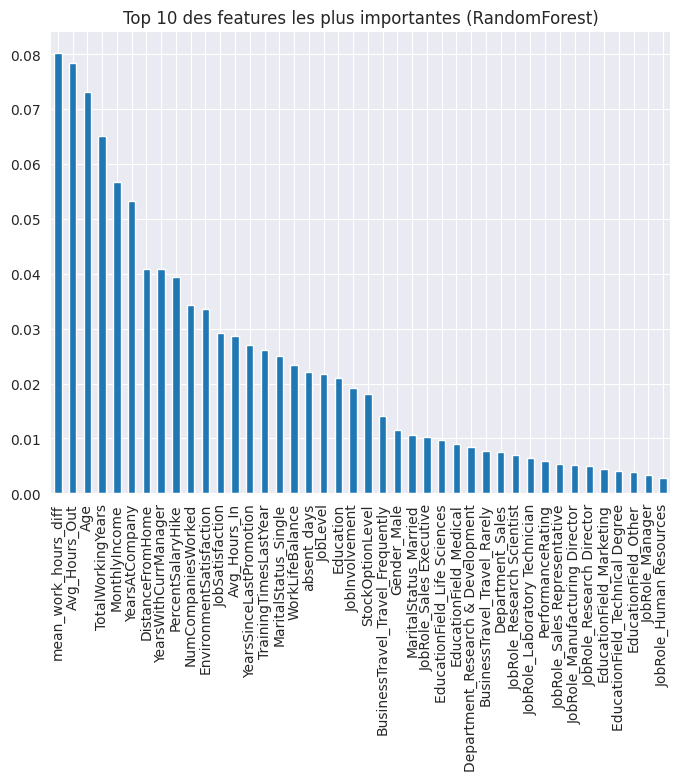

In [161]:
# Par exemple, on peut rapidement regarder l'importance des features dans le Random Forest :
importances = best_rf.feature_importances_
feature_names = X_train.columns
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print("\n=== Feature importances (RandomForest) ===\n", feat_importances.head(10))

# On peut éventuellement tracer un barplot pour visualiser
plt.figure(figsize=(8,6))
feat_importances.plot(kind='bar')
plt.title("Top 10 des features les plus importantes (RandomForest)")
plt.show()


# 10) Evaluation finale

## 10.1) Train et test scores

In [151]:
# On peut regarder les scores finaux sur le jeu de train et de test
print("\n=== Scores finaux ===")
print("Accuracy (Train) : ", accuracy_score(y_train, best_rf.predict(X_train)))
print("Accuracy (Test)  : ", accuracy_score(y_test, y_pred_best_rf))
print("ROC AUC  (Train) : ", roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1]))
print("ROC AUC  (Test)  : ", roc_auc_score(y_test, y_proba_best_rf))


=== Scores finaux ===
Accuracy (Train) :  1.0
Accuracy (Test)  :  0.9788359788359788
ROC AUC  (Train) :  1.0
ROC AUC  (Test)  :  0.9928477773548197


## 10.2) Courbe ROC

Nous pouvons constater que la courbe ROC a de bonnes performances pour le modèle Random Forest.

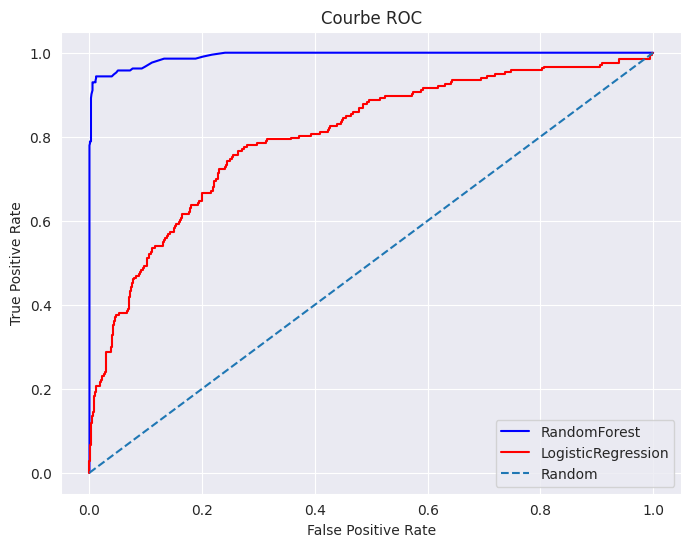

In [152]:
# On peut aussi tracer la courbe ROC
from sklearn.metrics import roc_curve

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_best_rf)
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_proba_best_lr)

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='RandomForest', c='b')
plt.plot(fpr_lr, tpr_lr, label='LogisticRegression', c='r')
plt.plot([0,1], [0,1], '--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Courbe ROC')

plt.legend()
plt.show()
